## Bibliotecas Utilizadas


In [ ]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

## Definições do Sistema

In [ ]:
'''Definicao da Transicao de Estados'''
def fs_(sp): 
    return sp

'''Definicao da Matriz de Medidas'''
def hs_(s, X):
    # print("s", s)
    # print("X", X)
    dot = s[0]*X[0] + s[1]*X[1]+s[2]*X[2]
    dot = np.dot(X.flatten(), s)
    D = np.tanh(dot)
    return D

## Algoritmos usados pelo Filtro de  Kalman

In [ ]:
def SigmaPoints(xm, P, kappa, kmax):
    n = xm.shape[0] # Considerando vetor-coluna!
    Xi = np.zeros((n,kmax))
    Ws = np.zeros((kmax,1))

    # Decomp. cholesky: U x U.T = (n+kp)*P
    U = cholesky((n+kappa)*P)
    Ws[0] = kappa / (n+kappa)
    Xi[:,0] = xm.flatten()
    for k in range(n):
        Xi[:, k+1] = xm.flatten() + U[k, :].T
        Ws[k+1] = 1 / (2*(n+kappa))

    for k in range(n): 
        Xi[:,n+k+1] = xm.flatten() - U[k, :].T
        Ws[n+k+1] = 1 / (2*(n+kappa))

    return Xi, Ws

def UT(Xi, W, noiseCov): 
    n, kmax = Xi.shape
    xm = np.zeros((n,1))
    xcov = np.zeros((n,n))

    '''Acumulacao do vetor xm'''
    for k in range(kmax):
        xm += W[k] * Xi[:, k].reshape((n,1))

    '''Acumulacao da matriz da Cov. de Medidas'''
    for k in range(kmax): 
        vec = (Xi[:,k].reshape((n,1)) - xm)
        xcov += W[k] * np.matmul(vec , vec.T)  
    xcov += noiseCov
    
    return xm, xcov

[[ 0.23884414]
 [-0.27342094]
 [-0.24725613]
 [ 0.51130592]]


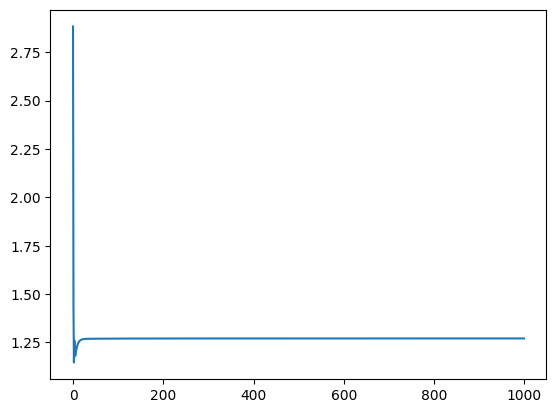

In [13]:
'''Declaração de Entrada e Saída Esperada'''
D = np.array([[0, 0, 0, 1]]).T
X = np.array([[0, 0, 1],
              [0, 1, 1],
              [1, 0, 1],
              [1, 1, 1]])

W = np.random.random((3,1)) -1 
#W = np.array([[-0.47399, 0.73467, 1.5124]]).T

'''Condicoes Iniciais'''
N = 1000
ns = W.size
nd = D.size
cost = np.zeros((N))
t = np.arange(N)

'''Modelagem do Sistema'''
P = np.eye(ns)
R = np.eye(nd)
Q = np.eye(ns)
z = D
s = W
kappa = 0
kmax = 2*ns+1

for i in range(N):    
    '''Processo de Sigma Points'''
    Si, Ws = SigmaPoints(s, P, kappa, kmax)
    fSi = np.zeros((ns,kmax))

    '''Estado de Update'''
    '''1. Propagacao em f(s)'''
    for k in range(kmax):
        fSi[:, k] = fs_(Si[:,k])

    '''2. Propagacao eh h(s)'''
    hSi = np.zeros((nd,kmax))
    h = np.zeros((nd,1))
    for k in range(kmax):
        for j in range(nd):
            h[j, :] = hs_(Si[:, k], X[j, :])
        hSi[:, k] = h.flatten()
    
    '''Transformacao Unscented - UT'''
    sp, Pp = UT(fSi, Ws, Q)
    zp, Pz = UT(hSi, Ws, R)

    Psz = np.zeros((ns, nd))
    for k in range(kmax):
        v1 = (fSi[:, k].reshape((ns, 1)) - sp).reshape((ns,1))
        v2 = (hSi[:, k].reshape((nd, 1)) - zp).reshape((nd,1))
        Psz += Ws[k] * np.matmul(v1,v2.T)
    
    '''Estado de Correcao'''
    error = z - zp
    inv_Pz = inv(Pz)
    K = np.matmul(Psz ,inv_Pz)
    s = sp + np.matmul(K, error)
    P = Pp - np.matmul(K, np.matmul(Pz,K.T))
    cost[i] = np.sum(np.abs(error))

print(error)
plt.figure()
plt.plot(t, cost)
plt.show()